In [37]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14}) #make plots more readable

import palettable as pal

import MagellanicStream as ms

import Calculate_Stellar_Field_Mass as fm #field mass

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

In [4]:
##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    '''
    - data: some 1d array-like object that possibly has duplicate values
    Returns dictionary of duplicates and array of indices
    '''
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

def dist2LMC(ra, dec, alph0, delt0, pa, io):
    '''
    - ra: right ascension of stars
    - dec: declination of stars
    - alph0: right ascension of center of LMC
    - delt0: declination of center of LMC
    - pa: position angle of line of nodes
    - io: inclination of LMC disk
    Calculate distance to stars in LMC assuming an inclined disk in the sky
    '''
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis


def sal(MH,aM):
    '''
    Calculate the Salaris correction to the overall metallicity
    '''
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat):
    '''
    Calculate the median absolute deviation of 1d array-like object dat
    '''
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [5]:
#########################
### Import fits files ###
#########################

#isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Structure/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers_r13-l33-58672.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#old dr16
olddr16 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembersdist_dr16beta.fits',1)
clnrold = np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))

clnrolddr16 = olddr16[clnrold]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/LMC_DR16_all_PDF.fits', 1)
clnpdfout = pdfout[ np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))]

#Read in Christian's Model
Chrismod = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Structure/abparam16_delgau1.5_1525.txt')

In [6]:
#######################
### Pick out Fields ###
#######################

dor30 = np.where(clndr16['FIELD']=='30Dor')
lmc1 = np.where(clndr16['FIELD']=='LMC1')
lmc2 = np.where(clndr16['FIELD']=='LMC2')
lmc3 = np.where(clndr16['FIELD']=='LMC3')
lmc4 = np.where(clndr16['FIELD']=='LMC4')
lmc5 = np.where(clndr16['FIELD']=='LMC5')
lmc6 = np.where(clndr16['FIELD']=='LMC6')
lmc7 = np.where(clndr16['FIELD']=='LMC7')
lmc8 = np.where(clndr16['FIELD']=='LMC8')
lmc9 = np.where(clndr16['FIELD']=='LMC9')
lmc10 = np.where(clndr16['FIELD']=='LMC10')
lmc11 = np.where(clndr16['FIELD']=='LMC11')
lmc12 = np.where(clndr16['FIELD']=='LMC12')
lmc13 = np.where(clndr16['FIELD']=='LMC13')
lmc14 = np.where(clndr16['FIELD']=='LMC14')
lmc16 = np.where(clndr16['FIELD']=='LMC16')
lmc17 = np.where(clndr16['FIELD']=='LMC17')

In [7]:
def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,\
       0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

In [8]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
# factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

stardist = dist2LMC(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist)-clndr16['AK_TARG']
parage = parsec_age(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],metscorr),clndr16['LOGG'])
parage = np.squeeze(parage)

In [9]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [10]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

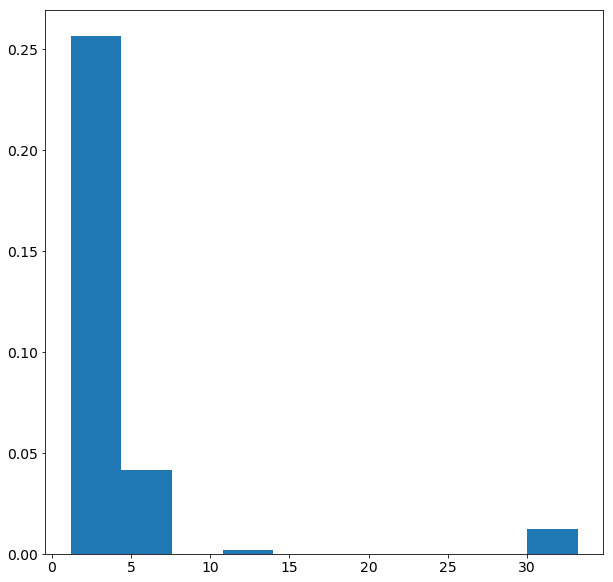

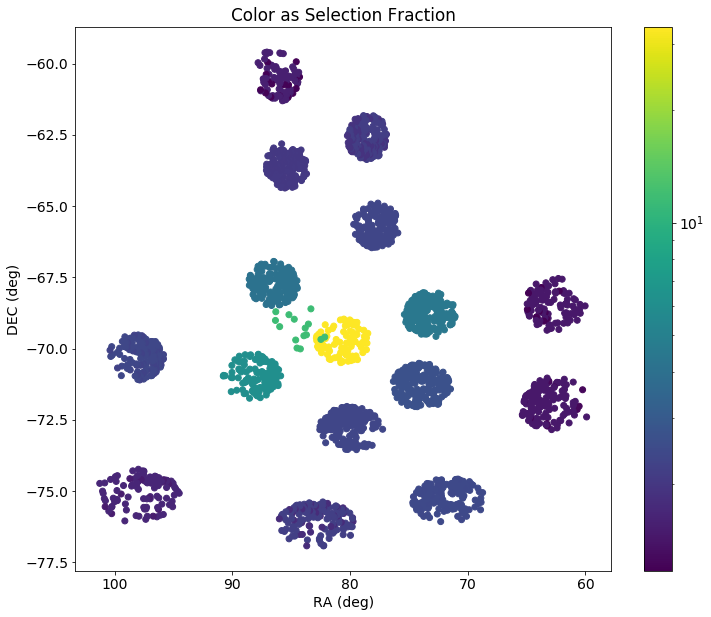

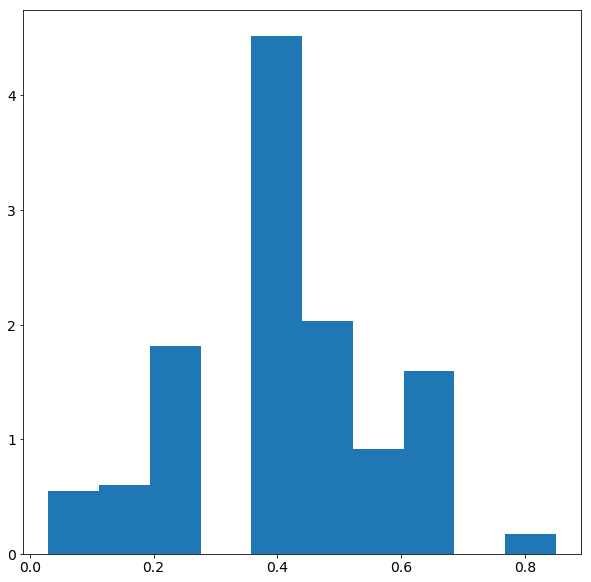

<Figure size 864x720 with 0 Axes>

In [11]:
##########################
### Look at SELECTFUNC ###
##########################

'''SELECTFUNC is the ration of RGB to total stars observed'''

#histogram
plt.figure(figsize=[10,10])
plt.hist(clndr16['SELECTFUNC'],density=True)
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['RA'],clndr16['DEC'],c=clndr16['SELECTFUNC'],norm=matplotlib.colors.LogNorm())
plt.gca().invert_xaxis()
plt.title(r'Color as Selection Fraction')
plt.colorbar()
plt.xlabel(r'RA (deg)')
plt.ylabel(r'DEC (deg)')
plt.show()

plt.figure(figsize=[10,10])
plt.hist(np.reciprocal(clndr16['SELECTFUNC']),density=True)
plt.figure(figsize=[12,10])
plt.show()

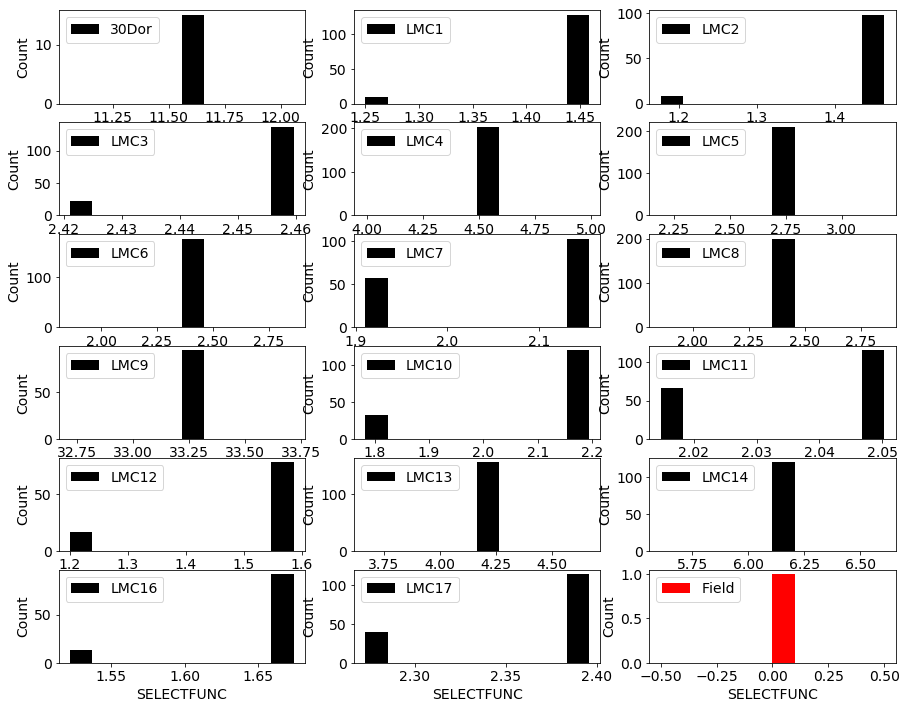

In [12]:
f, ax = plt.subplots(6,3, facecolor='w',figsize=(15,12))
ax[0,0].hist(clndr16['SELECTFUNC'][dor30],color='k',label='30Dor')
ax[0,0].set_xlabel('SELECTFUNC')
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('Count')

ax[0,1].hist(clndr16['SELECTFUNC'][lmc1],color='k',label='LMC1')
ax[0,1].set_xlabel('SELECTFUNC')
ax[0,1].legend(loc='upper left')
ax[0,1].set_ylabel('Count')

ax[0,2].hist(clndr16['SELECTFUNC'][lmc2],color='k',label='LMC2')
ax[0,2].set_xlabel('SELECTFUNC')
ax[0,2].legend(loc='upper left')
ax[0,2].set_ylabel('Count')

ax[1,0].hist(clndr16['SELECTFUNC'][lmc3],color='k',label='LMC3')
ax[1,0].set_xlabel('SELECTFUNC')
ax[1,0].legend(loc='upper left')
ax[1,0].set_ylabel('Count')

ax[1,1].hist(clndr16['SELECTFUNC'][lmc4],color='k',label='LMC4')
ax[1,1].set_xlabel('SELECTFUNC')
ax[1,1].legend(loc='upper left')
ax[1,1].set_ylabel('Count')

ax[1,2].hist(clndr16['SELECTFUNC'][lmc5],color='k',label='LMC5')
ax[1,2].set_xlabel('SELECTFUNC')
ax[1,2].legend(loc='upper left')
ax[1,2].set_ylabel('Count')

ax[2,0].hist(clndr16['SELECTFUNC'][lmc6],color='k',label='LMC6')
ax[2,0].set_xlabel('SELECTFUNC')
ax[2,0].legend(loc='upper left')
ax[2,0].set_ylabel('Count')

ax[2,1].hist(clndr16['SELECTFUNC'][lmc7],color='k',label='LMC7')
ax[2,1].set_xlabel('SELECTFUNC')
ax[2,1].legend(loc='upper left')
ax[2,1].set_ylabel('Count')

ax[2,2].hist(clndr16['SELECTFUNC'][lmc8],color='k',label='LMC8')
ax[2,2].set_xlabel('SELECTFUNC')
ax[2,2].legend(loc='upper left')
ax[2,2].set_ylabel('Count')

ax[3,0].hist(clndr16['SELECTFUNC'][lmc9],color='k',label='LMC9')
ax[3,0].set_xlabel('SELECTFUNC')
ax[3,0].legend(loc='upper left')
ax[3,0].set_ylabel('Count')

ax[3,1].hist(clndr16['SELECTFUNC'][lmc10],color='k',label='LMC10')
ax[3,1].set_xlabel('SELECTFUNC')
ax[3,1].legend(loc='upper left')
ax[3,1].set_ylabel('Count')

ax[3,2].hist(clndr16['SELECTFUNC'][lmc11],color='k',label='LMC11')
ax[3,2].set_xlabel('SELECTFUNC')
ax[3,2].legend(loc='upper left')
ax[3,2].set_ylabel('Count')

ax[4,0].hist(clndr16['SELECTFUNC'][lmc12],color='k',label='LMC12')
ax[4,0].set_xlabel('SELECTFUNC')
ax[4,0].legend(loc='upper left')
ax[4,0].set_ylabel('Count')

ax[4,1].hist(clndr16['SELECTFUNC'][lmc13],color='k',label='LMC13')
ax[4,1].set_xlabel('SELECTFUNC')
ax[4,1].legend(loc='upper left')
ax[4,1].set_ylabel('Count')

ax[4,2].hist(clndr16['SELECTFUNC'][lmc14],color='k',label='LMC14')
ax[4,2].set_xlabel('SELECTFUNC')
ax[4,2].legend(loc='upper left')
ax[4,2].set_ylabel('Count')

ax[5,0].hist(clndr16['SELECTFUNC'][lmc16],color='k',label='LMC16')
ax[5,0].set_xlabel('SELECTFUNC')
ax[5,0].legend(loc='upper left')
ax[5,0].set_ylabel('Count')

ax[5,1].hist(clndr16['SELECTFUNC'][lmc17],color='k',label='LMC17')
ax[5,1].set_xlabel('SELECTFUNC')
ax[5,1].legend(loc='upper left')
ax[5,1].set_ylabel('Count')

ax[5,2].hist(0,color='r',label='Field')
ax[5,2].set_xlabel('SELECTFUNC')
ax[5,2].legend(loc='upper left')
ax[5,2].set_ylabel('Count')

f.show()

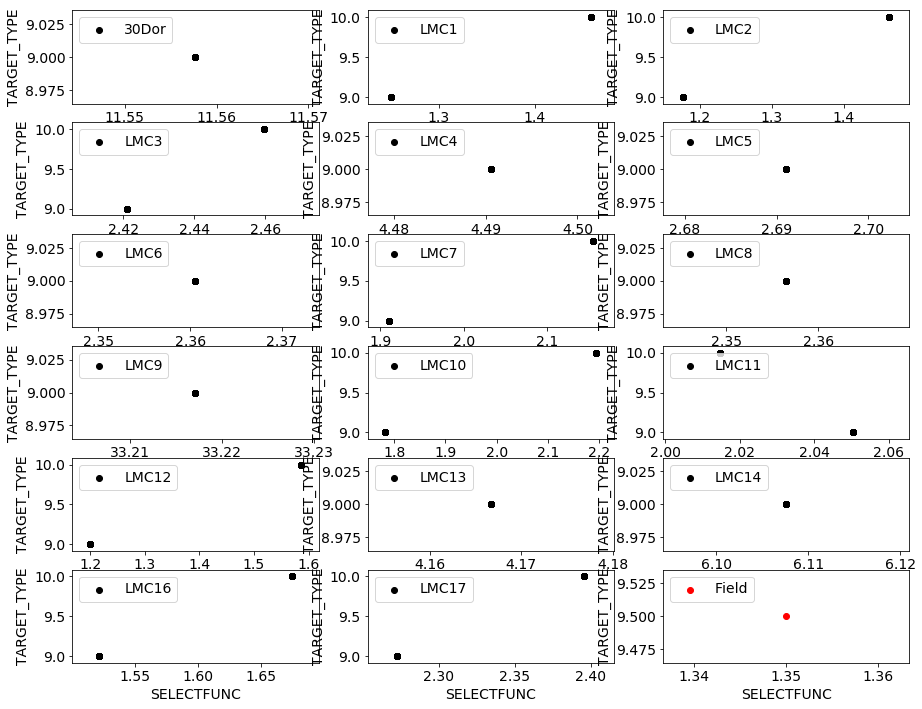

In [13]:
f, ax = plt.subplots(6,3, facecolor='w',figsize=(15,12))
ax[0,0].scatter(clndr16['SELECTFUNC'][dor30],clndr16['TARGET_TYPE'][dor30],color='k',label='30Dor')
ax[0,0].set_xlabel('SELECTFUNC')
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('TARGET_TYPE')

ax[0,1].scatter(clndr16['SELECTFUNC'][lmc1],clndr16['TARGET_TYPE'][lmc1],color='k',label='LMC1')
ax[0,1].set_xlabel('SELECTFUNC')
ax[0,1].legend(loc='upper left')
ax[0,1].set_ylabel('TARGET_TYPE')

ax[0,2].scatter(clndr16['SELECTFUNC'][lmc2],clndr16['TARGET_TYPE'][lmc2],color='k',label='LMC2')
ax[0,2].set_xlabel('SELECTFUNC')
ax[0,2].legend(loc='upper left')
ax[0,2].set_ylabel('TARGET_TYPE')

ax[1,0].scatter(clndr16['SELECTFUNC'][lmc3],clndr16['TARGET_TYPE'][lmc3],color='k',label='LMC3')
ax[1,0].set_xlabel('SELECTFUNC')
ax[1,0].legend(loc='upper left')
ax[1,0].set_ylabel('TARGET_TYPE')

ax[1,1].scatter(clndr16['SELECTFUNC'][lmc4],clndr16['TARGET_TYPE'][lmc4],color='k',label='LMC4')
ax[1,1].set_xlabel('SELECTFUNC')
ax[1,1].legend(loc='upper left')
ax[1,1].set_ylabel('TARGET_TYPE')

ax[1,2].scatter(clndr16['SELECTFUNC'][lmc5],clndr16['TARGET_TYPE'][lmc5],color='k',label='LMC5')
ax[1,2].set_xlabel('SELECTFUNC')
ax[1,2].legend(loc='upper left')
ax[1,2].set_ylabel('TARGET_TYPE')

ax[2,0].scatter(clndr16['SELECTFUNC'][lmc6],clndr16['TARGET_TYPE'][lmc6],color='k',label='LMC6')
ax[2,0].set_xlabel('SELECTFUNC')
ax[2,0].legend(loc='upper left')
ax[2,0].set_ylabel('TARGET_TYPE')

ax[2,1].scatter(clndr16['SELECTFUNC'][lmc7],clndr16['TARGET_TYPE'][lmc7],color='k',label='LMC7')
ax[2,1].set_xlabel('SELECTFUNC')
ax[2,1].legend(loc='upper left')
ax[2,1].set_ylabel('TARGET_TYPE')

ax[2,2].scatter(clndr16['SELECTFUNC'][lmc8],clndr16['TARGET_TYPE'][lmc8],color='k',label='LMC8')
ax[2,2].set_xlabel('SELECTFUNC')
ax[2,2].legend(loc='upper left')
ax[2,2].set_ylabel('TARGET_TYPE')

ax[3,0].scatter(clndr16['SELECTFUNC'][lmc9],clndr16['TARGET_TYPE'][lmc9],color='k',label='LMC9')
ax[3,0].set_xlabel('SELECTFUNC')
ax[3,0].legend(loc='upper left')
ax[3,0].set_ylabel('TARGET_TYPE')

ax[3,1].scatter(clndr16['SELECTFUNC'][lmc10],clndr16['TARGET_TYPE'][lmc10],color='k',label='LMC10')
ax[3,1].set_xlabel('SELECTFUNC')
ax[3,1].legend(loc='upper left')
ax[3,1].set_ylabel('TARGET_TYPE')

ax[3,2].scatter(clndr16['SELECTFUNC'][lmc11],clndr16['TARGET_TYPE'][lmc11],color='k',label='LMC11')
ax[3,2].set_xlabel('SELECTFUNC')
ax[3,2].legend(loc='upper left')
ax[3,2].set_ylabel('TARGET_TYPE')

ax[4,0].scatter(clndr16['SELECTFUNC'][lmc12],clndr16['TARGET_TYPE'][lmc12],color='k',label='LMC12')
ax[4,0].set_xlabel('SELECTFUNC')
ax[4,0].legend(loc='upper left')
ax[4,0].set_ylabel('TARGET_TYPE')

ax[4,1].scatter(clndr16['SELECTFUNC'][lmc13],clndr16['TARGET_TYPE'][lmc13],color='k',label='LMC13')
ax[4,1].set_xlabel('SELECTFUNC')
ax[4,1].legend(loc='upper left')
ax[4,1].set_ylabel('TARGET_TYPE')

ax[4,2].scatter(clndr16['SELECTFUNC'][lmc14],clndr16['TARGET_TYPE'][lmc14],color='k',label='LMC14')
ax[4,2].set_xlabel('SELECTFUNC')
ax[4,2].legend(loc='upper left')
ax[4,2].set_ylabel('TARGET_TYPE')

ax[5,0].scatter(clndr16['SELECTFUNC'][lmc16],clndr16['TARGET_TYPE'][lmc16],color='k',label='LMC16')
ax[5,0].set_xlabel('SELECTFUNC')
ax[5,0].legend(loc='upper left')
ax[5,0].set_ylabel('TARGET_TYPE')

ax[5,1].scatter(clndr16['SELECTFUNC'][lmc17],clndr16['TARGET_TYPE'][lmc17],color='k',label='LMC17')
ax[5,1].set_xlabel('SELECTFUNC')
ax[5,1].legend(loc='upper left')
ax[5,1].set_ylabel('TARGET_TYPE')

ax[5,2].scatter(1.35,9.5,color='r',label='Field')
ax[5,2].set_xlabel('SELECTFUNC')
ax[5,2].legend(loc='upper left')
ax[5,2].set_ylabel('TARGET_TYPE')

f.show()

In [14]:
print(set(np.copy(clndr16['TARGET_NAME'])))
print(set(np.copy(clndr16['TARGET_TYPE'])))
print(clndr16['TARGET_NAME'][0])
print(clndr16['TARGET_TYPE'][0])

{'BrtRGB', 'FntRGB'}
{9, 10}
BrtRGB
9


Text(0, 0.5, 'H')

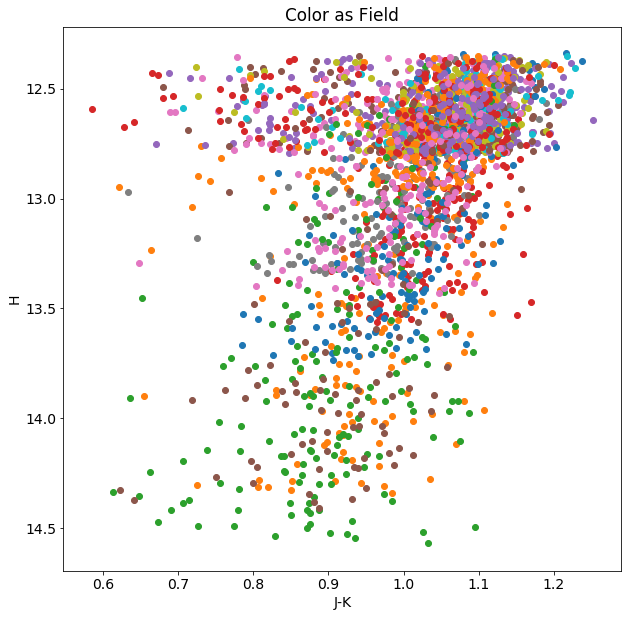

In [15]:
###################################
### HR Diagram Colored by Field ###
###################################

plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K'])[dor30],clndr16['H'][dor30])
plt.scatter((clndr16['J']-clndr16['K'])[lmc1],clndr16['H'][lmc1])
plt.scatter((clndr16['J']-clndr16['K'])[lmc2],clndr16['H'][lmc2])
plt.scatter((clndr16['J']-clndr16['K'])[lmc3],clndr16['H'][lmc3])
plt.scatter((clndr16['J']-clndr16['K'])[lmc4],clndr16['H'][lmc4])
plt.scatter((clndr16['J']-clndr16['K'])[lmc5],clndr16['H'][lmc5])
plt.scatter((clndr16['J']-clndr16['K'])[lmc6],clndr16['H'][lmc6])
plt.scatter((clndr16['J']-clndr16['K'])[lmc7],clndr16['H'][lmc7])
plt.scatter((clndr16['J']-clndr16['K'])[lmc8],clndr16['H'][lmc8])
plt.scatter((clndr16['J']-clndr16['K'])[lmc9],clndr16['H'][lmc9])
plt.scatter((clndr16['J']-clndr16['K'])[lmc10],clndr16['H'][lmc10])
plt.scatter((clndr16['J']-clndr16['K'])[lmc11],clndr16['H'][lmc11])
plt.scatter((clndr16['J']-clndr16['K'])[lmc12],clndr16['H'][lmc12])
plt.scatter((clndr16['J']-clndr16['K'])[lmc13],clndr16['H'][lmc13])
plt.scatter((clndr16['J']-clndr16['K'])[lmc14],clndr16['H'][lmc14])
plt.scatter((clndr16['J']-clndr16['K'])[lmc16],clndr16['H'][lmc16])
plt.scatter((clndr16['J']-clndr16['K'])[lmc17],clndr16['H'][lmc17])
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Color as Field')
plt.ylabel('H')

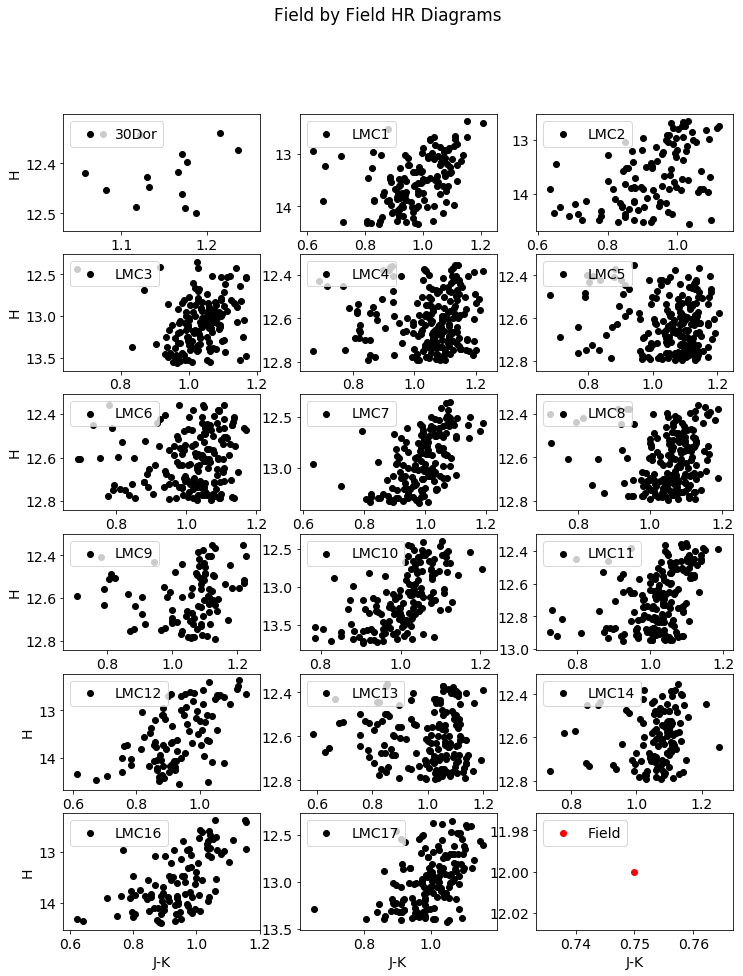

In [16]:
#############################
### HR Diagram for fields ###
#############################

f, ax = plt.subplots(6,3, facecolor='w',figsize=(12,15))
ax[0,0].scatter((clndr16['J']-clndr16['K'])[dor30],clndr16['H'][dor30],color='k',label='30Dor')
# ax[0,0].set_xlabel('J-k')
ax[0,0].legend(loc='upper left')
ax[0,0].invert_yaxis()
ax[0,0].set_ylabel('H')

ax[0,1].scatter((clndr16['J']-clndr16['K'])[lmc1],clndr16['H'][lmc1],color='k',label='LMC1')
# ax[0,1].set_xlabel('J-K')
ax[0,1].legend(loc='upper left')
ax[0,1].invert_yaxis()
# ax[0,1].set_ylabel('H')

ax[0,2].scatter((clndr16['J']-clndr16['K'])[lmc2],clndr16['H'][lmc2],color='k',label='LMC2')
# ax[0,2].set_xlabel('J-k')
ax[0,2].legend(loc='upper left')
ax[0,2].invert_yaxis()
# ax[0,2].set_ylabel('H')

ax[1,0].scatter((clndr16['J']-clndr16['K'])[lmc3],clndr16['H'][lmc3],color='k',label='LMC3')
# ax[1,0].set_xlabel('J-k')
ax[1,0].legend(loc='upper left')
ax[1,0].invert_yaxis()
ax[1,0].set_ylabel('H')

ax[1,1].scatter((clndr16['J']-clndr16['K'])[lmc4],clndr16['H'][lmc4],color='k',label='LMC4')
# ax[1,1].set_xlabel('J-K')
ax[1,1].legend(loc='upper left')
ax[1,1].invert_yaxis()
# ax[1,1].set_ylabel('H')

ax[1,2].scatter((clndr16['J']-clndr16['K'])[lmc5],clndr16['H'][lmc5],color='k',label='LMC5')
# ax[1,2].set_xlabel('J-K')
ax[1,2].legend(loc='upper left')
ax[1,2].invert_yaxis()
# ax[1,2].set_ylabel('H')

ax[2,0].scatter((clndr16['J']-clndr16['K'])[lmc6],clndr16['H'][lmc6],color='k',label='LMC6')
# ax[2,0].set_xlabel('J-K')
ax[2,0].legend(loc='upper left')
ax[2,0].invert_yaxis()
ax[2,0].set_ylabel('H')

ax[2,1].scatter((clndr16['J']-clndr16['K'])[lmc7],clndr16['H'][lmc7],color='k',label='LMC7')
# ax[2,1].set_xlabel('J-K')
ax[2,1].legend(loc='upper left')
ax[2,1].invert_yaxis()
# ax[2,1].set_ylabel('H')

ax[2,2].scatter((clndr16['J']-clndr16['K'])[lmc8],clndr16['H'][lmc8],color='k',label='LMC8')
# ax[2,2].set_xlabel('J-K')
ax[2,2].legend(loc='upper left')
ax[2,2].invert_yaxis()
# ax[2,2].set_ylabel('H')

ax[3,0].scatter((clndr16['J']-clndr16['K'])[lmc9],clndr16['H'][lmc9],color='k',label='LMC9')
# ax[3,0].set_xlabel('J-K')
ax[3,0].legend(loc='upper left')
ax[3,0].invert_yaxis()
ax[3,0].set_ylabel('H')

ax[3,1].scatter((clndr16['J']-clndr16['K'])[lmc10],clndr16['H'][lmc10],color='k',label='LMC10')
# ax[3,1].set_xlabel('J-K')
ax[3,1].legend(loc='upper left')
ax[3,1].invert_yaxis()
# ax[3,1].set_ylabel('H')

ax[3,2].scatter((clndr16['J']-clndr16['K'])[lmc11],clndr16['H'][lmc11],color='k',label='LMC11')
# ax[3,2].set_xlabel('J-K')
ax[3,2].legend(loc='upper left')
ax[3,2].invert_yaxis()
# ax[3,2].set_ylabel('H')

ax[4,0].scatter((clndr16['J']-clndr16['K'])[lmc12],clndr16['H'][lmc12],color='k',label='LMC12')
# ax[4,0].set_xlabel('J-K')
ax[4,0].legend(loc='upper left')
ax[4,0].invert_yaxis()
ax[4,0].set_ylabel('H')

ax[4,1].scatter((clndr16['J']-clndr16['K'])[lmc13],clndr16['H'][lmc13],color='k',label='LMC13')
# ax[4,1].set_xlabel('J-K')
ax[4,1].legend(loc='upper left')
ax[4,1].invert_yaxis()
# ax[4,1].set_ylabel('H')

ax[4,2].scatter((clndr16['J']-clndr16['K'])[lmc14],clndr16['H'][lmc14],color='k',label='LMC14')
# ax[4,2].set_xlabel('J-K')
ax[4,2].legend(loc='upper left')
ax[4,2].invert_yaxis()
# ax[4,2].set_ylabel('H')

ax[5,0].scatter((clndr16['J']-clndr16['K'])[lmc16],clndr16['H'][lmc16],color='k',label='LMC16')
ax[5,0].set_xlabel('J-K')
ax[5,0].legend(loc='upper left')
ax[5,0].invert_yaxis()
ax[5,0].set_ylabel('H')

ax[5,1].scatter((clndr16['J']-clndr16['K'])[lmc17],clndr16['H'][lmc17],color='k',label='LMC17')
ax[5,1].set_xlabel('J-K')
ax[5,1].legend(loc='upper left')
ax[5,1].invert_yaxis()
# ax[5,1].set_ylabel('H')

ax[5,2].scatter(0.75,12,color='r',label='Field')
ax[5,2].set_xlabel('J-K')
ax[5,2].legend(loc='upper left')
ax[5,2].invert_yaxis()
# ax[5,2].set_ylabel('H')

f.suptitle(r'Field by Field HR Diagrams')
f.show()

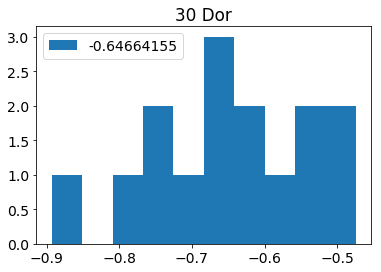

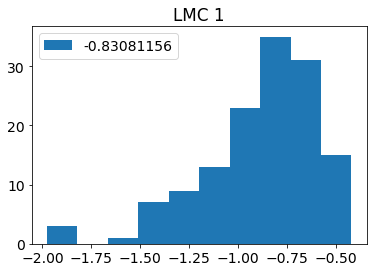

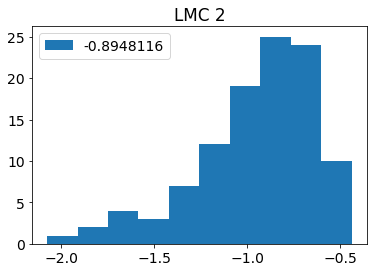

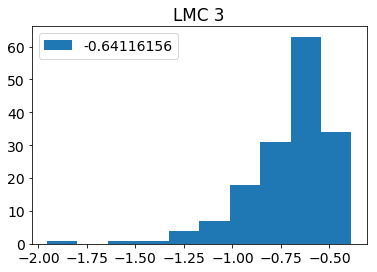

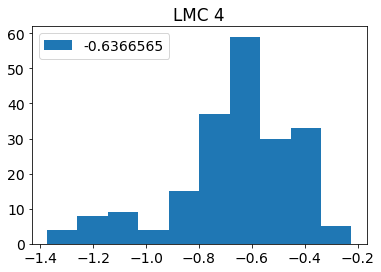

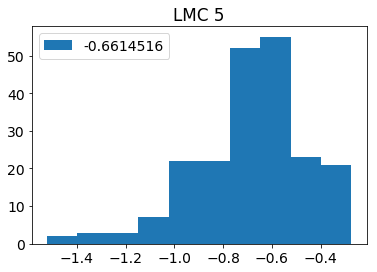

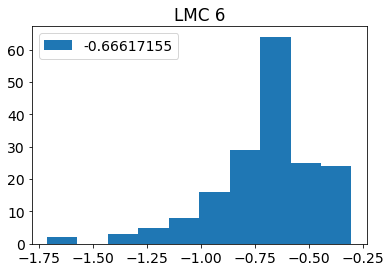

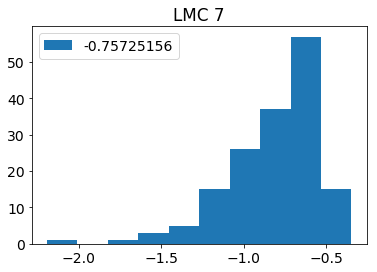

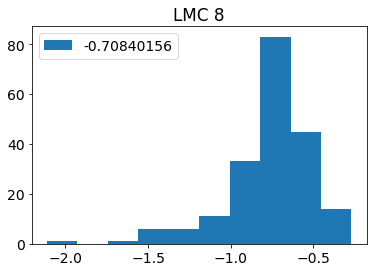

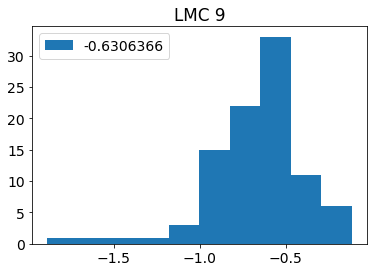

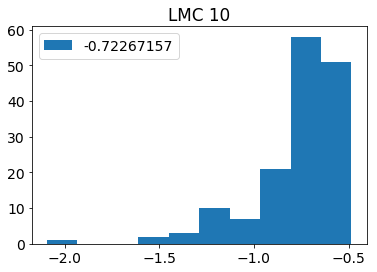

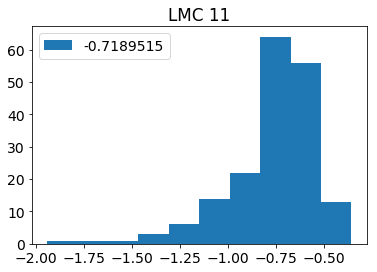

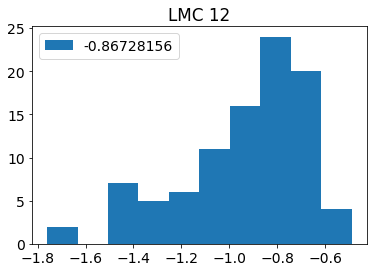

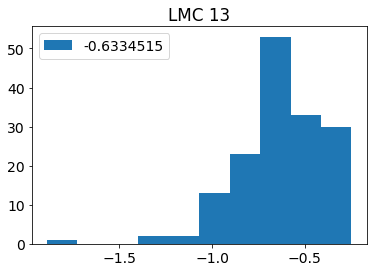

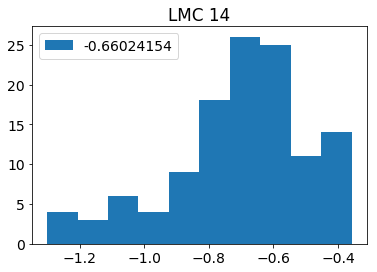

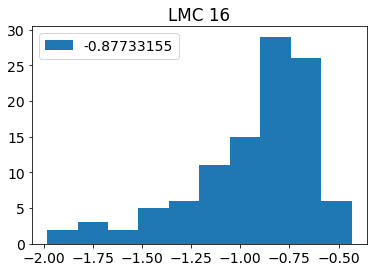

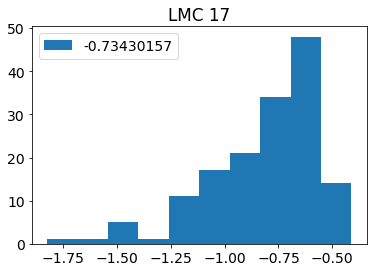

In [31]:
#30Dor
plt.hist(clndr16['FE_H'][dor30],label=str(np.median(clndr16['FE_H'][dor30])))
plt.legend(loc='upper left')
plt.title(r'30 Dor')
plt.show()

#LMC1
plt.hist(clndr16['FE_H'][lmc1],label=str(np.median(clndr16['FE_H'][lmc1])))
plt.legend(loc='upper left')
plt.title(r'LMC 1')
plt.show()

#LMC2
plt.hist(clndr16['FE_H'][lmc2],label=str(np.median(clndr16['FE_H'][lmc2])))
plt.legend(loc='upper left')
plt.title(r'LMC 2')
plt.show()

#LMC3
plt.hist(clndr16['FE_H'][lmc3],label=str(np.median(clndr16['FE_H'][lmc3])))
plt.legend(loc='upper left')
plt.title(r'LMC 3')
plt.show()

#LMC4
plt.hist(clndr16['FE_H'][lmc4],label=str(np.median(clndr16['FE_H'][lmc4])))
plt.legend(loc='upper left')
plt.title(r'LMC 4')
plt.show()

#LMC5
plt.hist(clndr16['FE_H'][lmc5],label=str(np.median(clndr16['FE_H'][lmc5])))
plt.legend(loc='upper left')
plt.title(r'LMC 5')
plt.show()

#LMC5
plt.hist(clndr16['FE_H'][lmc6],label=str(np.median(clndr16['FE_H'][lmc6])))
plt.legend(loc='upper left')
plt.title(r'LMC 6')
plt.show()

#LMC7
plt.hist(clndr16['FE_H'][lmc7],label=str(np.median(clndr16['FE_H'][lmc7])))
plt.legend(loc='upper left')
plt.title(r'LMC 7')
plt.show()

#LMC8
plt.hist(clndr16['FE_H'][lmc8],label=str(np.median(clndr16['FE_H'][lmc8])))
plt.legend(loc='upper left')
plt.title(r'LMC 8')
plt.show()

#LMC9
plt.hist(clndr16['FE_H'][lmc9],label=str(np.median(clndr16['FE_H'][lmc9])))
plt.legend(loc='upper left')
plt.title(r'LMC 9')
plt.show()

#LMC10
plt.hist(clndr16['FE_H'][lmc10],label=str(np.median(clndr16['FE_H'][lmc10])))
plt.legend(loc='upper left')
plt.title(r'LMC 10')
plt.show()

#LMC11
plt.hist(clndr16['FE_H'][lmc11],label=str(np.median(clndr16['FE_H'][lmc11])))
plt.legend(loc='upper left')
plt.title(r'LMC 11')
plt.show()

#LMC12
plt.hist(clndr16['FE_H'][lmc12],label=str(np.median(clndr16['FE_H'][lmc12])))
plt.legend(loc='upper left')
plt.title(r'LMC 12')
plt.show()

#LMC13
plt.hist(clndr16['FE_H'][lmc13],label=str(np.median(clndr16['FE_H'][lmc13])))
plt.legend(loc='upper left')
plt.title(r'LMC 13')
plt.show()

#LMC14
plt.hist(clndr16['FE_H'][lmc14],label=str(np.median(clndr16['FE_H'][lmc14])))
plt.legend(loc='upper left')
plt.title(r'LMC 14')
plt.show()

#LMC16
plt.hist(clndr16['FE_H'][lmc16],label=str(np.median(clndr16['FE_H'][lmc16])))
plt.legend(loc='upper left')
plt.title(r'LMC 16')
plt.show()

#LMC17
plt.hist(clndr16['FE_H'][lmc17],label=str(np.median(clndr16['FE_H'][lmc17])))
plt.legend(loc='upper left')
plt.title(r'LMC 17')
plt.show()

In [47]:
#############################################
### Mass of Fields with only Bright stars ###
#############################################

corabsH = absmag(clndr16['H'],stardist)-clndr16['AK_TARG']

'(age, met, maxAbs, minAbs, select, len(field))'

#30 Dor
mass30dor=fm.apogee_field_mass(8.7,-0.65,max(corabsH[dor30]),min(corabsH[dor30]),clndr16[dor30]['SELECTFUNC'][0],
                    len(np.squeeze(dor30)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 4
masslmc4=fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc4]),min(corabsH[lmc4]),clndr16[lmc4]['SELECTFUNC'][0],
                    len(np.squeeze(lmc4)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 5
masslmc5=fm.apogee_field_mass(8.7,-0.66,max(corabsH[lmc5]),min(corabsH[lmc5]),clndr16[lmc5]['SELECTFUNC'][0],
                    len(np.squeeze(lmc5)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 6
masslmc6=fm.apogee_field_mass(8.7,-0.67,max(corabsH[lmc6]),min(corabsH[lmc6]),clndr16[lmc6]['SELECTFUNC'][0],
                    len(np.squeeze(lmc6)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 8
masslmc8=fm.apogee_field_mass(8.7,-0.63,max(corabsH[lmc8]),min(corabsH[lmc8]),clndr16[lmc8]['SELECTFUNC'][0],
                    len(np.squeeze(lmc8)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 9
masslmc9=fm.apogee_field_mass(8.7,-0.63,max(corabsH[lmc9]),min(corabsH[lmc9]),clndr16[lmc9]['SELECTFUNC'][0],
                    len(np.squeeze(lmc9)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 13
masslmc13=fm.apogee_field_mass(8.7,-0.63,max(corabsH[lmc13]),min(corabsH[lmc13]),clndr16[lmc13]['SELECTFUNC'][0],
                    len(np.squeeze(lmc13)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 14
masslmc14=fm.apogee_field_mass(8.7,-0.66,max(corabsH[lmc14]),min(corabsH[lmc14]),clndr16[lmc14]['SELECTFUNC'][0],
                    len(np.squeeze(lmc14)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')

In [49]:
########################################################
### Mass of Fields with composite Bright/Faint stars ###
########################################################

fnt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='FntRGB')
fnt2 = np.where(clndr16[lmc2]['TARGET_NAME']=='FntRGB')
fnt3 = np.where(clndr16[lmc3]['TARGET_NAME']=='FntRGB')
fnt7 = np.where(clndr16[lmc7]['TARGET_NAME']=='FntRGB')
fnt10 = np.where(clndr16[lmc10]['TARGET_NAME']=='FntRGB')
fnt11 = np.where(clndr16[lmc11]['TARGET_NAME']=='FntRGB')
fnt12 = np.where(clndr16[lmc12]['TARGET_NAME']=='FntRGB')
fnt16 = np.where(clndr16[lmc16]['TARGET_NAME']=='FntRGB')
fnt17 = np.where(clndr16[lmc17]['TARGET_NAME']=='FntRGB')

brt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='BrtRGB')
brt2 = np.where(clndr16[lmc2]['TARGET_NAME']=='BrtRGB')
brt3 = np.where(clndr16[lmc3]['TARGET_NAME']=='BrtRGB')
brt7 = np.where(clndr16[lmc7]['TARGET_NAME']=='BrtRGB')
brt10 = np.where(clndr16[lmc10]['TARGET_NAME']=='BrtRGB')
brt11 = np.where(clndr16[lmc11]['TARGET_NAME']=='BrtRGB')
brt12 = np.where(clndr16[lmc12]['TARGET_NAME']=='BrtRGB')
brt16 = np.where(clndr16[lmc16]['TARGET_NAME']=='BrtRGB')
brt17 = np.where(clndr16[lmc17]['TARGET_NAME']=='BrtRGB')

#LMC 1
fntlmc1 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc1][fnt1]),min(corabsH[lmc1][fnt1]),
                             clndr16[lmc1][fnt1]['SELECTFUNC'][0],len(np.squeeze(fnt1)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc1 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc1][brt1]),min(corabsH[lmc1][brt1]),
                             clndr16[lmc1][brt1]['SELECTFUNC'][0],len(np.squeeze(brt1)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc1 = fntlmc1+brtlmc1

#LMC 2
fntlmc2 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc2][fnt2]),min(corabsH[lmc2][fnt2]),
                             clndr16[lmc2][fnt2]['SELECTFUNC'][0],len(np.squeeze(fnt2)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc2 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc2][brt2]),min(corabsH[lmc2][brt2]),
                             clndr16[lmc2][brt2]['SELECTFUNC'][0],len(np.squeeze(brt2)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc2 = fntlmc2+brtlmc2

#LMC 3
fntlmc3 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc3][fnt3]),min(corabsH[lmc3][fnt3]),
                             clndr16[lmc3][fnt3]['SELECTFUNC'][0],len(np.squeeze(fnt3)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc3 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc3][brt3]),min(corabsH[lmc3][brt3]),
                             clndr16[lmc3][brt3]['SELECTFUNC'][0],len(np.squeeze(brt3)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc3 = fntlmc3+brtlmc3

#LMC 7
fntlmc7 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc7][fnt7]),min(corabsH[lmc7][fnt7]),
                             clndr16[lmc7][fnt7]['SELECTFUNC'][0],len(np.squeeze(fnt7)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc7 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc7][brt7]),min(corabsH[lmc7][brt7]),
                             clndr16[lmc7][brt7]['SELECTFUNC'][0],len(np.squeeze(brt7)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc7 = fntlmc7+brtlmc7

#LMC 10
fntlmc10 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc10][fnt10]),min(corabsH[lmc10][fnt10]),
                             clndr16[lmc10][fnt10]['SELECTFUNC'][0],len(np.squeeze(fnt10)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc10 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc10][brt10]),min(corabsH[lmc10][brt10]),
                             clndr16[lmc10][brt10]['SELECTFUNC'][0],len(np.squeeze(brt10)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc10 = fntlmc10+brtlmc10

#LMC 11
fntlmc11 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc11][fnt11]),min(corabsH[lmc11][fnt11]),
                             clndr16[lmc11][fnt11]['SELECTFUNC'][0],len(np.squeeze(fnt11)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc11 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc11][brt11]),min(corabsH[lmc11][brt11]),
                             clndr16[lmc11][brt11]['SELECTFUNC'][0],len(np.squeeze(brt11)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc11 = fntlmc11+brtlmc11

#LMC 12
fntlmc12 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc12][fnt12]),min(corabsH[lmc12][fnt12]),
                             clndr16[lmc12][fnt12]['SELECTFUNC'][0],len(np.squeeze(fnt12)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc12 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc12][brt12]),min(corabsH[lmc12][brt12]),
                             clndr16[lmc12][brt12]['SELECTFUNC'][0],len(np.squeeze(brt12)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc12 = fntlmc12+brtlmc12

#LMC 16
fntlmc16 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc16][fnt16]),min(corabsH[lmc16][fnt16]),
                             clndr16[lmc16][fnt16]['SELECTFUNC'][0],len(np.squeeze(fnt16)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc16 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc16][brt16]),min(corabsH[lmc16][brt16]),
                             clndr16[lmc16][brt16]['SELECTFUNC'][0],len(np.squeeze(brt16)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc16 = fntlmc16+brtlmc16

#LMC 17
fntlmc17 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc17][fnt17]),min(corabsH[lmc17][fnt17]),
                             clndr16[lmc17][fnt17]['SELECTFUNC'][0],len(np.squeeze(fnt17)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc17 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc17][brt17]),min(corabsH[lmc17][brt17]),
                             clndr16[lmc17][brt17]['SELECTFUNC'][0],len(np.squeeze(brt17)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc17 = fntlmc17+brtlmc17

In [54]:
#######################################
### All Field Masses and Total Mass ###
#######################################

print('30 Dor: '+str(mass30dor)+' Msol')
print('LMC 1: '+str(masslmc1)+' Msol')
print('LMC 2: '+str(masslmc2)+' Msol')
print('LMC 3: '+str(masslmc3)+' Msol')
print('LMC 4: '+str(masslmc4)+' Msol')
print('LMC 5: '+str(masslmc5)+' Msol')
print('LMC 6: '+str(masslmc6)+' Msol')
print('LMC 7: '+str(masslmc7)+' Msol')
print('LMC 8: '+str(masslmc8)+' Msol')
print('LMC 9: '+str(masslmc9)+' Msol')
print('LMC 10: '+str(masslmc10)+' Msol')
print('LMC 11: '+str(masslmc11)+' Msol')
print('LMC 12: '+str(masslmc12)+' Msol')
print('LMC 13: '+str(masslmc13)+' Msol')
print('LMC 14: '+str(masslmc14)+' Msol')
print('LMC 16: '+str(masslmc16)+' Msol')
print('LMC 17: '+str(masslmc17)+' Msol')
print('LMC RGB total: '+str((mass30dor+masslmc1+masslmc3+masslmc4+masslmc5+masslmc6+masslmc7+masslmc8+masslmc9+
                      masslmc10+masslmc11+masslmc12+masslmc13+masslmc14+masslmc16+masslmc17)/(10**9))+' Msol')


30 Dor: 34699779.15164701 Msol
LMC 1: 5640275.6946826605 Msol
LMC 2: 6599964.434149263 Msol
LMC 3: 25819102.2809336 Msol
LMC 4: 73100490.3433117 Msol
LMC 5: 65618971.20853537 Msol
LMC 6: 46602826.04507137 Msol
LMC 7: 29085415.40914861 Msol
LMC 8: 57630907.80229962 Msol
LMC 9: 318542818.3535509 Msol
LMC 10: 18705515.681413576 Msol
LMC 11: 63019680.329684205 Msol
LMC 12: 4604893.509065007 Msol
LMC 13: 66435529.54068977 Msol
LMC 14: 83497866.18328515 Msol
LMC 16: 5522471.322000369 Msol
LMC 17: 28915825.510063313 Msol
LMC RGB total: 0.9274423683653823 Msol
